In [41]:
import os

In [42]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/Kevin_fiminqv/Desktop/big_data/bq_sa.json'

In [43]:
from google.cloud import bigquery
import db_dtypes
import pyarrow

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_predictions(data):
    if 'name' in data.columns:
        data = data.drop(['name', 'age', 'gender','patient_id', 'load_timestamp'], axis=1)
    prob_data = data.iloc[0]
    top_3 = prob_data.nlargest(3)
    others = pd.Series(prob_data.drop(top_3.index).sum(), index=['Other'])
    pie_data = pd.concat([top_3, others])
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99'] 
    fig, ax = plt.subplots()
    ax.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=90, colors=colors)
    ax.axis('equal')
    plt.title("Top 3 Model Probability Predictions with Distinguishable Colors")
    plt.show()

In [45]:
def generate_symptom_barchart_from_csv(output_data, training_data, symptoms_data):
    training_data = training_data.iloc[:, :-1]
    probabilities = output_data.drop(['name', 'age', 'gender','patient_id','load_timestamp'], axis=1).iloc[0]
    top_3_diseases = probabilities.nlargest(3).index.tolist()
    relevant_symptoms = training_data[training_data["prognosis"].isin(top_3_diseases)]
    symptom_columns = [col for col in symptoms_data.columns if col not in ['name', 'age', 'gender','patient_id', 'load_timestamp']]
    symptoms_series = symptoms_data.iloc[0][symptom_columns]
    for disease in top_3_diseases:
        disease_data = relevant_symptoms[relevant_symptoms['prognosis'] == disease]
        symptom_counts = disease_data[symptom_columns].sum()
        symptoms_to_plot = symptom_counts[symptoms_series == 0].nlargest(5)
        if not symptoms_to_plot.empty:
            symptoms_to_plot = symptoms_to_plot[symptoms_to_plot > 0]
            if symptoms_to_plot.empty:
                continue    
            fig, ax = plt.subplots()
            bars = symptoms_to_plot.plot(kind='bar', ax=ax, color="grey")
            ax.set_title(f'Top 5 Symptoms for {disease} (Absent in Test but Present in Training)')
            ax.set_ylabel('Count of Symptoms')
            ax.set_xlabel('Symptoms')
            plt.xticks(rotation=45)
            for bar in bars.patches:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', 
                        ha='center', va='bottom')
            plt.tight_layout()
            plt.show()
        else:
            print(f"No symptoms to plot for {disease}.")

In [46]:
def plots(id_number):
    client = bigquery.Client()
    symptoms_data = client.query(f"""SELECT * FROM `sharp-imprint-420622.Disease.incomingdata` WHERE patient_id = {id_number} ORDER BY load_timestamp DESC
LIMIT 1;""" ).result().to_dataframe()
    training_data = client.query(f"""SELECT * FROM `sharp-imprint-420622.Disease.training`""" ).result().to_dataframe()
    output_data = client.query(f"""SELECT * FROM `sharp-imprint-420622.Disease.inference` WHERE patient_id = {id_number} ORDER BY load_timestamp DESC
LIMIT 1;""" ).result().to_dataframe()
    plot_model_predictions(output_data)
    generate_symptom_barchart_from_csv(output_data, training_data, symptoms_data)

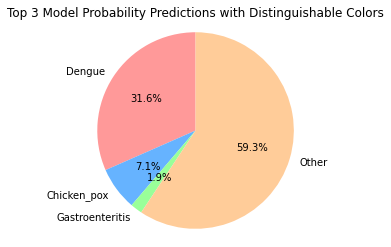

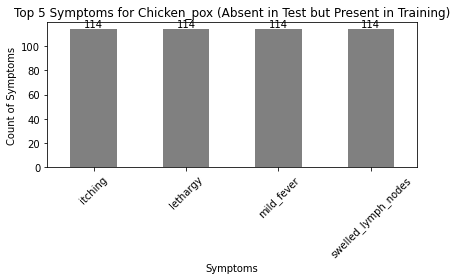

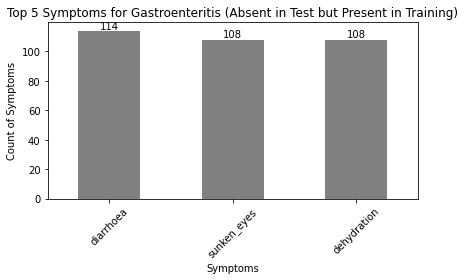

In [50]:
plots(43276)

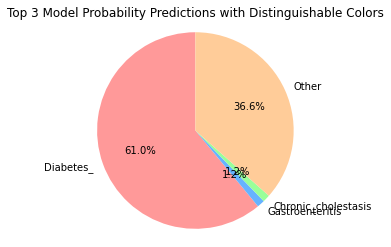

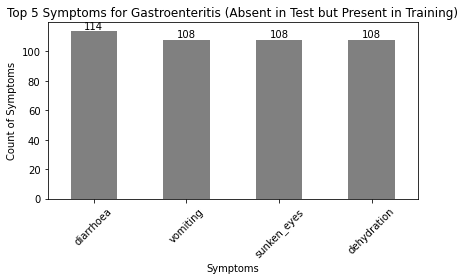

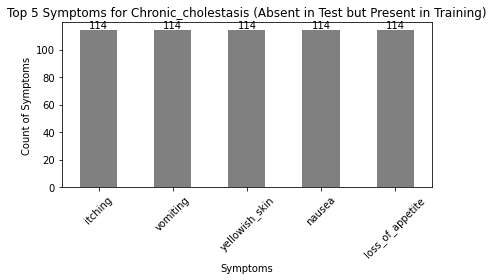

In [51]:
plots(42019)

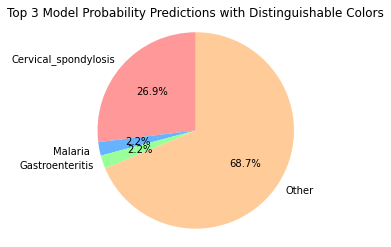

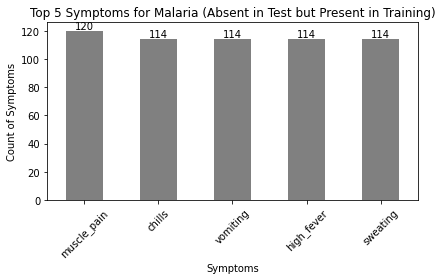

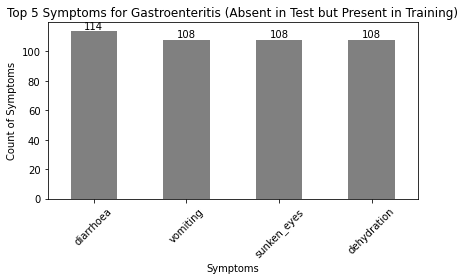

In [52]:
plots(23105)

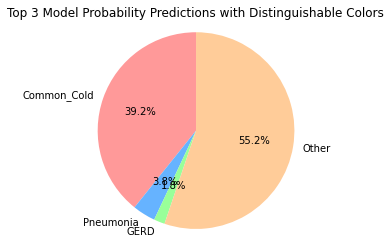

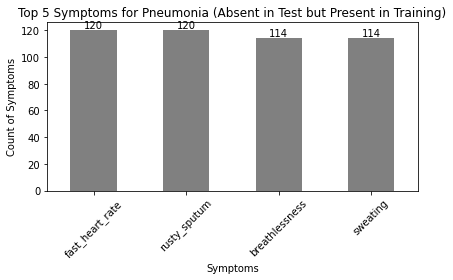

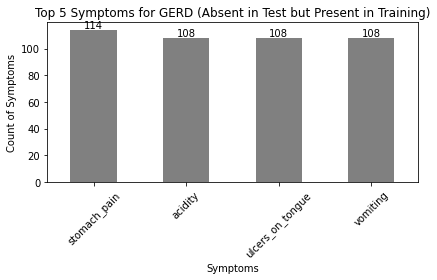

In [53]:
plots(27137)

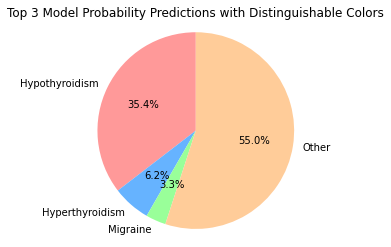

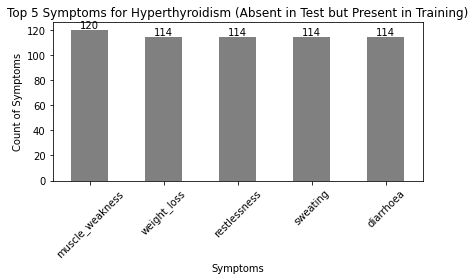

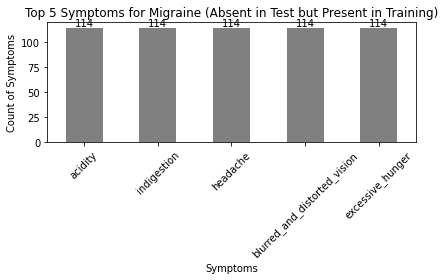

In [54]:
plots(79234)